## Credit default model
The purpose of this project is to create a model that is able to predict whether a loan will be defaulted based on a set of attributes of the individuals.

### Summary of results

### 0. Importing libraries and data, and general setup

#### Importing libraries and setting up the environment

In [393]:
# Importing libraries Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
import datetime as dt
import time as tm
# Keep graphs in line
%matplotlib inline
# Show all columns in pandas
pd.set_option('max_columns', None)
# Graphing style
plt.style.use('seaborn-colorblind')

#### Importing data from csv files

In [394]:
# Importing training data provided
df_train = pd.read_csv('data/train.csv')
# Converting all column names into lowercase and removing any spaces
df_train.columns = [x.strip().lower() for x in df_train.columns]
# Importing testing data
df_test = pd.read_csv('data/test.csv')
# Converting all column names into lowercase and removing any spaces
df_test.columns = [x.strip().lower() for x in df_test.columns]

### 1. Exploratory data analysis and data cleaning

#### Understanding data shapes
We are provided with the following two sets of data containing information about past costumers including their payment behavior. 
- A training dataset that will be used to train and calibrate the parameters of our model, containing 16,671 observations with 11 attributes and 1 target variable to predict.
- A testing dataset that will be used to test the model that we create with brand new observations and see the performance, including 4,168 observations with the same 11 attributes but no target.

Both datasets contain the same attributes. 

In [395]:
# Printing shapes of the datasets
# Training datset shape
print('Training dataset')
print('- Observations:', str(df_train.shape[0]))
print('- Attributes:', str(df_train.shape[1] - 2))          # ID and Target is not an actual attribute
print('- Target:', str(1))
# Testing dataset
print('Testing dataset')
print('- Observations:', str(df_test.shape[0]))
print('- Attributes:', str(df_test.shape[1] - 1))           # ID is not an actual attribute
# Verifying variables
#print('\n')
if list(df_train.columns[0:-1]) == list(df_test.columns): 
    print('Variables consistency: No issues')


Training dataset
- Observations: 16671
- Attributes: 11
- Target: 1
Testing dataset
- Observations: 4168
- Attributes: 11
Variables consistency: No issues


#### Understanding attributes
The table below contains a general summary of the variables we were provided, including the count, mean, standard deviation, and location measures. In addition, it included a column that tracks any missing valyes in the data as well as the data types. 
For the training dataset we have the following variables: 

- *id*: A unique identificator of each of the clients.

    No repeated ids, implying that each client has only been grante one loan. 

- *date_of_birth*: Birth date of the client.

- *number_dependants*: Number of people that depend directly on the client's income.

- *credit_utilization*: % of the credit limit that the individual has used. 

- *debt_to_income_ratio*: Ratio of debt to income.

- *monthly_income*: Total income that the client receives on a monthly basis.

- *number_open_credit_lines*: Number of opened credit lines that the client has. 

- *number_open_loans*: Numer of loans that the client has received that haven't been paid off

- *number_90_days_past_due*: Number of debt products in which the client has 90+ days past- due

- *number_charged_off*: Number of debt accounts in which the client has been charged off

- *score1*: Credit score of the individual obtained before the loan/credit line was granted

- *score2*: Credit score of the individual obtained bafter the loan/credit line was paid off of or defaulted.

    Both scores show the same range of values and in some cases the difference is quite large.

- *target*: Binary variable that shows if an individual defaulted (1 if defaulted and 0 if not)

From this original set of variables there are a few others that we can safely infer that might be useful for the analysis: 

- *age*: Age of the individual.

- *income_per_member* (*monthly_income* / *number_dependants*): Income per household member. 

- *total_debt* (*debt_to_income_ratio* * *monthly_income*): Total debt accounts of the individual.

- *number_accounts* (*number_open_credit_lines* + *number_open_loans*): Total number of debt accounts of the indivudual.

- *avg_loan* (*total_debt* / *number_accounts*): Averge laon amount non-paid by the individual. 
 
    Knowing the original amount of the accounts would be better to obtain variables such as monthly payments

- *90_days_pct* (*number_90_days_past_due* / *number_accounts*): Percentage of accounts with 90 days past-due.

- *charged_off_pct* (*number_charged_off* / *number_accounts*): Percentage of accounts charged off.

- *score_pct_change* (*score2* - *score1*) / *score1*:  Percent change of the credit score. 



In [396]:
# Function to summarize data
def summary_stats(data, title):  
    """
    Generates a Summary table containing the most relevant information of a dataset

    Parameters:
    ----------
    data : dataframe
        Data to summarize
    title : str
        Title of the graph

    Returns:
    --------
    Dataframe
    """ 
    # Generate a general summary of the variables
    df_missingval = pd.DataFrame(data.isna().any(), columns=['Missing vals'])                   # Check if there are any missing values
    df_types = pd.DataFrame(data.dtypes, columns=['Variable type'])                             # Obtain the datatypes of all colums
    df_describe = data.describe().round(decimals=2).transpose()                                 # Generate summary statistics
    _ = pd.merge(df_missingval, df_types, how='inner', left_index=True, right_index=True)       # Intermediate merge types and missing val
    df_var_summary = pd.merge(df_describe, _ , how='outer', left_index=True, right_index=True)  # Final merge 
    df_var_summary.loc['date_of_birth', 'count'] = len(data.index)                              # Replace count of date_of_birth
    print(title.center(120))

    return df_var_summary

quant_cols = df_train.columns.drop(['id', 'date_of_birth'])                                     # Create a list of quantitative columns

# Applying function to traiinng data
title = 'Table 1. Summary of variables training set'
summary_stats(df_train, title)



                                       Table 1. Summary of variables training set                                       


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
credit_utilization,16671.0,0.05,0.05,0.00,0.01,0.03,0.07,0.54,False,float64
date_of_birth,16671.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,object
debt_to_income_ratio,16671.0,0.33,0.12,0.03,0.25,0.33,0.41,0.80,False,float64
id,16671.0,10917.57,6309.00,1.00,5474.50,10967.00,16349.00,21839.00,False,int64
monthly_income,16671.0,2289.90,319.47,2000.00,2100.00,2200.00,2400.00,5000.00,False,int64
number_90_days_past_due,16671.0,0.10,0.32,0.00,0.00,0.00,0.00,3.00,False,int64
number_charged_off,16671.0,0.10,0.32,0.00,0.00,0.00,0.00,3.00,False,int64
number_dependants,16671.0,0.49,0.72,-1.00,0.00,0.00,1.00,6.00,False,int64
number_open_credit_lines,16671.0,5.00,2.25,0.00,3.00,5.00,6.00,15.00,False,int64
number_open_loans,16671.0,2.03,1.43,0.00,1.00,2.00,3.00,9.00,False,int64


In [397]:
# Applying function to testing data
title = 'Table 2. Summary of variables testing set'
summary_stats(df_test, title)

                                       Table 2. Summary of variables testing set                                        


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
credit_utilization,4168.0,0.05,0.05,0.00,0.01,0.04,0.07,0.30,False,float64
date_of_birth,4168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,object
debt_to_income_ratio,4168.0,0.33,0.12,0.04,0.24,0.32,0.41,0.76,False,float64
id,4168.0,10949.44,6242.32,4.00,5521.75,10795.50,16431.25,21838.00,False,int64
monthly_income,4168.0,2294.27,322.57,2000.00,2100.00,2200.00,2400.00,4300.00,False,int64
number_90_days_past_due,4168.0,0.10,0.31,0.00,0.00,0.00,0.00,3.00,False,int64
number_charged_off,4168.0,0.10,0.31,0.00,0.00,0.00,0.00,3.00,False,int64
number_dependants,4168.0,0.47,0.72,-1.00,0.00,0.00,1.00,5.00,False,int64
number_open_credit_lines,4168.0,4.99,2.24,0.00,3.00,5.00,6.00,15.00,False,int64
number_open_loans,4168.0,2.02,1.43,0.00,1.00,2.00,3.00,9.00,False,int64


#### Understanding target
Because we are trying to predict a binary variable, it is important to know what is the proportion of defaulted loans that are recorded. 
Figure 1 shows the percentage of defaulted vs Non-defaulted loans. We have a quite unbalanced sample, with Non-default loans representing around 90% of the total observations, and Defaul loans representing only 10% of the observations. 

Trying to preserve this proportions will be important when splitting the data to test the model's performance.

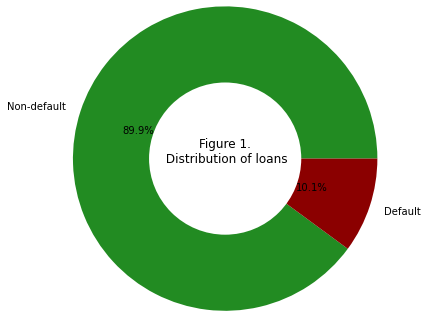

In [398]:
type_frequencies = df_train['target'].value_counts(normalize='true')

fig, ax = plt.subplots()
ax.pie(type_frequencies, labels=['Non-default', 'Default'], autopct='%1.1f%%', radius=2, colors=['forestgreen', 'darkred'])
fig.set_size_inches(3.5,3.5)
circle = plt.Circle(xy=(0,0), radius=1, facecolor='White')
plt.gca().add_artist(circle)
ax.set_title('Figure 1.\n Distribution of loans', y=0.45)

plt.savefig('figures/target_pie.png')

#### Validating popultions consistency
Before doing any further analysis, it is important to verify that the distributions of both the training and the testing samples were drawn from populations with the same distributions. If this wasn't the case, it would be like trying to predict the behavior of people in the US studying data of people from UK, and therefore, our analysis would lack validity and consistency. 

To perform this evaluation, the Kolmogorov-Smirnov for two samples test (KS2) was used. This test evaluates the hypothesis that both samples were drawn from the same distribution. The graph below shows the Kernel Density Estimations (KDE) for every variable of each samples. Only by scanning the graphs, it is very clear that both samples show similar distributions for all the variables involved. We can also verify that by taking a look at the KS2 p-values. Using a 95% confidence level, as long as the p-value is greater than 0.05, we cannot reject the hypothesis that both samples were drawn from the same distribution. In this case, all the p-values obtained are greater than 0.05, hence, we can confidently move forward knowing that any result obtained will be applicabble to our testing set. 

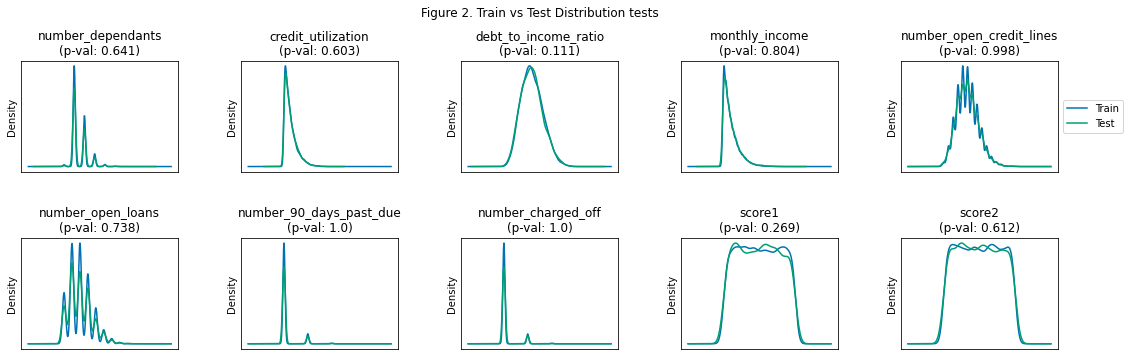

In [399]:
# Plot of the distribution of variables between training and testing
fig, ax = plt.subplots(2,5)                     # Create a 5x2 grid of subplots
fig.set_size_inches((18,5))
fig.suptitle('Figure 2. Train vs Test Distribution tests', y=1.05)
plt.subplots_adjust(left=0.1,                   # Adjust the space between the subplots
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 2
for row in range(2):                                                        # Rows loop
    for col in range(5):                                                    # Columns loop
        current_col = df_train.columns[col_index]                           # Curent column
        p_val = ks_2samp(df_train[current_col], df_test[current_col])[1]    # Kolmogorov-Smirnov test for goodness of fit (p-val)
        ax[row][col].set_title(current_col + '\n' + 
                             '(p-val: {})'.format(round(p_val, 3)))
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=False, right=False, labelleft=False, labelbottom=False)
        df_train[current_col].plot.kde(ax=ax[row][col])
        df_test[current_col].plot.kde(ax=ax[row][col])
        col_index += 1
    
ax[0][4].legend(['Train', 'Test'], loc='center left', bbox_to_anchor=(1, 0.5))

# Save image
plt.savefig('figures/train_vs_test_dist.png')

#### Handling missing values
As shown in the previous table, none of the columns contain any missing information. However, column number_dependants contains minumim values of (-1), which, given the nature of the variable, is not possible. Some data sources tend to use (-1) to reflect missing values after processing the data to avoid showing NaN values. Therefore, we will assume that such observations represent missing information, and will be treated as such. 

In the training dataset 

In [400]:
# Number of missing values of dependants column
count_missing_train = len(df_train[df_train['number_dependants'] == -1])
count_missing_test = len(df_test[df_test['number_dependants'] == -1])

print('Total missing values : {}'.format(count_missing_train))
print('Total missing values : {}'.format(count_missing_test))

Total missing values : 178
Total missing values : 31


#### Generating new variables

After generating the variables discussed previously, we get a final dataset with the same 16,671 observations, 17 attributes, and 1 target to predict.


In [401]:
# Create function that computes new variables for any of the datasets
def gen_variables(data):
    """ 
    Creates the list of new variables mentioned in section 1. 
    
    Parameters:
    ----------
    data : dataframe
        Original dataframe to transform
    
    Returns: 
    -------
    dataframe
        A dataframe with the new variables

    """
    df = data
    # Generate age
    today = pd.Timestamp(dt.date.today())                                                   # Get today's date
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], infer_datetime_format=True)   # Convert column into datetime
    df['age'] = df['date_of_birth'].apply(lambda x: (today - pd.Timestamp(x)).days)         # Calculate dif between dates
    df['age'] = round(df['age'] / 365, 0)                                                   # Convert into years
    df['age'] = df['age'].astype(int)                                                       # Convert column into integer
    df = df.drop(columns=['date_of_birth', 'id'])                                           # Drop date of birth and id column                                             

    # Generate income per member
    df['income_per_member'] = df['monthly_income'] / (df['number_dependants'] + 1)          # + 1 to Count the client 

    # Generate total debt
    df['total_debt'] = df['debt_to_income_ratio'] * df['monthly_income']

    # Generate number_accounts
    df['number_accounts'] = df['number_open_credit_lines'] + df['number_open_loans']

    # Generate avg loan
    df['avg_loan'] = df['total_debt'] / df['number_accounts']

    # Generate 90 days pct
    df['90_days_pct'] = df['number_90_days_past_due'] / df['number_accounts']

    # Generate charged_off_pct
    df['charged_off_pct'] = df['number_charged_off'] / df['number_accounts']

    # Generate score pct change
    df['score_pct_change'] = (df['score2'] - df['score1']) / df['score1']
    
    return df

# Create new df with original and new variables
df_train_new = gen_variables(df_train)

print('New Training dataset')
print('- Observations:', str(df_train_new.shape[0]))
print('- Attributes:', str(df_train_new.shape[1] - 2))          # ID and Target is not an actual attribute
print('- Target:', str(1))

New Training dataset
- Observations: 16671
- Attributes: 17
- Target: 1


#### Scales and extreme values
Figure 3 is showing the Boxplots for all original variables. It is clear that we are dealing with different scales (e.g. number_dependants ranges from 0 to 6 while monthly_income ranges from 2,000 to 5,000). 

To correct this issue we must transformate our data with some standarization technique, so our analysis can be focused on the relationship between the variables and not on the scale in which the variation is presented
Standardized data is essential for accurate data analysis; it’s easier to draw clear conclusions about your current data when you have other data to measure it against using the same units. 

Standarization will also allow us to reduce any potential skew that outlyers might have over our sample. From Figure 2, it easy to see that all the data, except from scores 1 and 2, include some outlyers. In particular, 90 days past due and charged off accounts seem to present some very extreme observations. This will be something to keep in mind when evaluating the performance of the model.


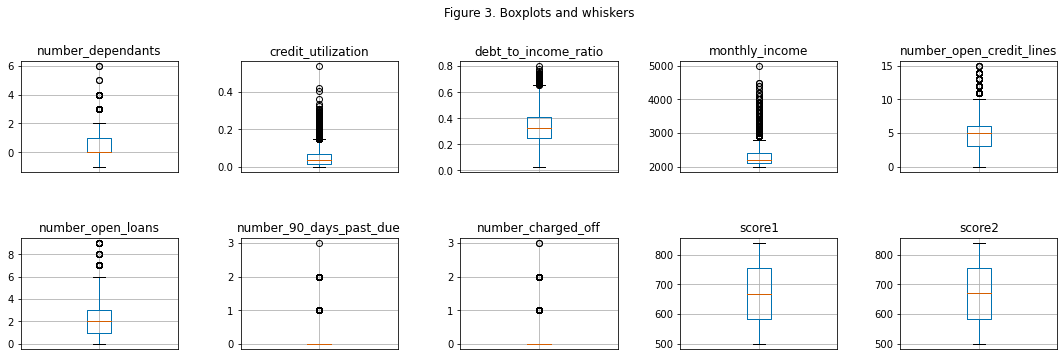

In [402]:
# Generate boxplots for each variable
fig, ax = plt.subplots(2,5)                     # Create a 5x2 grid of subplots
fig.set_size_inches((18,5))
fig.suptitle('Figure 3. Boxplots and whiskers', y=1.05)
plt.subplots_adjust(left=0.1,                   # Adjust the space between the subplots
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 0
for row in range(2):                                                        # Rows loop
    for col in range(5):                                                    # Columns loop
        current_col = quant_cols[col_index]                                 # Curent column
        ax[row][col].set_title(current_col)
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=True, right=False, labelleft=True, labelbottom=False)
        df_train.boxplot(column=[current_col], ax=ax[row][col])
        col_index += 1
plt.savefig('figures/boxplots.png')

#### Standarization function

In [403]:
def standarize(data, y_col = 'target'): 
    """
    This function  standarizes the values of our datasets
    
    Parameters:
    ------------
    data : dataframe
        Dataset to transform
    y_col : str
        Name of the target column
    x_cols : list
        List of attributes to transform
    
    Returns:
    --------
    dataframe
        A dataframe with the data standarized
    """

    x_cols = list(data.columns)
    x_cols.remove(str(y_col))

    # Separate target from attributes
    X = data[x_cols]                                       # Remove target columns and id
    y = data[y_col]                                        # Target column

    scaler = MinMaxScaler()                                # Generate scaler object
    X_scaled = scaler.fit_transform(X)
    df = pd.DataFrame(X_scaled)
    

    return df  


In [405]:
#standarize(df_train_new)

In [406]:
df_train_new.iloc[640]


number_dependants             -1.000000
credit_utilization             0.099829
debt_to_income_ratio           0.384028
monthly_income              2100.000000
number_open_credit_lines       6.000000
number_open_loans              1.000000
number_90_days_past_due        0.000000
number_charged_off             0.000000
score1                       632.000000
score2                       587.000000
target                         0.000000
age                           27.000000
income_per_member                   inf
total_debt                   806.459069
number_accounts                7.000000
avg_loan                     115.208438
90_days_pct                    0.000000
charged_off_pct                0.000000
score_pct_change              -0.071203
Name: 640, dtype: float64

#### Exploring correlations between variables

<AxesSubplot:>

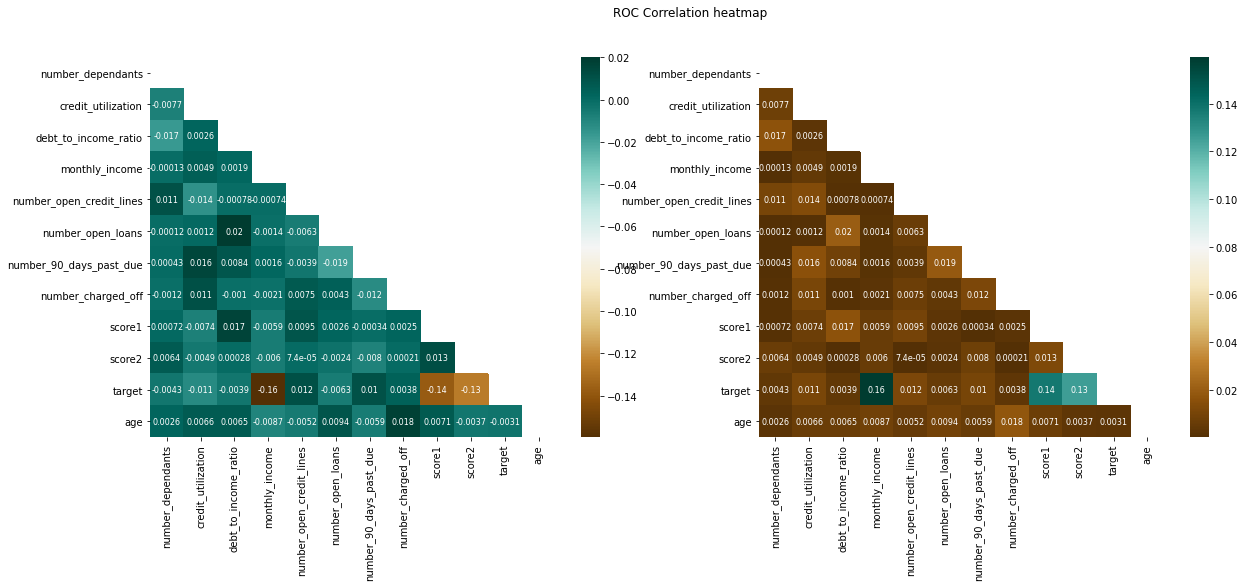

In [407]:
# Creating correlation matrix graph
fig, ax = plt.subplots(1,2)   
fig.set_size_inches((20,7))                                                  # Create a 5x2 grid of subplots
plt.suptitle('ROC Correlation heatmap')
# Mask that allows us to get only the diagonal values 
mask = np.triu(np.ones_like(df_train.drop(columns='id').corr(), dtype=np.bool))
# Graphing correlation matrix with original sign
sns.heatmap(df_train.drop(columns='id').corr(), annot=True, mask=mask, cmap='BrBG', 
            ax=ax[0], annot_kws={"size": 8})
# Graphing correlation matrix with absolute value
sns.heatmap(df_train.drop(columns='id').corr().abs(), annot=True, mask=mask, 
            cmap='BrBG', ax=ax[1], annot_kws={"size": 8})



In [408]:
df_train

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
0,1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0,30
1,2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0,56
2,3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0,92
3,5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0,79
4,6,1994-02-03,0,0.001003,0.251700,2500,6,6,0,1,830,587,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16666,21833,1975-09-01,0,0.108978,0.457906,2100,6,1,0,0,760,793,0,47
16667,21834,1941-02-01,1,0.014642,0.540975,2000,12,1,0,0,717,512,0,82
16668,21835,1960-04-09,0,0.003702,0.182518,2900,3,1,0,0,602,644,0,62
16669,21837,1999-01-28,2,0.014581,0.202639,2400,6,1,0,0,599,544,0,24
